# Finding the Minumum Variance Portfolio
The optimization will minimize
$$\sigma_p^2 = w^T \Sigma w$$

Subject to

$$\sum_{i=1}^n w_i = 1$$
$$w_i \geq 0 \space \text{for all i}$$

where $\Sigma$ is the covariance matrix and $w$ is the vector of weights we're solving for

In [67]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.cluster import hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Filter out future warnings
import warnings
warnings.filterwarnings('ignore')

In [68]:
# random seed for reproducibility
np.random.seed(42)

In [69]:
tickers = ['SALM.OL', 'NVDA', 'BLK', 'AMZN', 'ABBV', 'MTN']

In [70]:
end_date = datetime.now()
start_date = end_date - timedelta(days=365*3)

In [71]:
df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)['Close']
    df[ticker] = data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


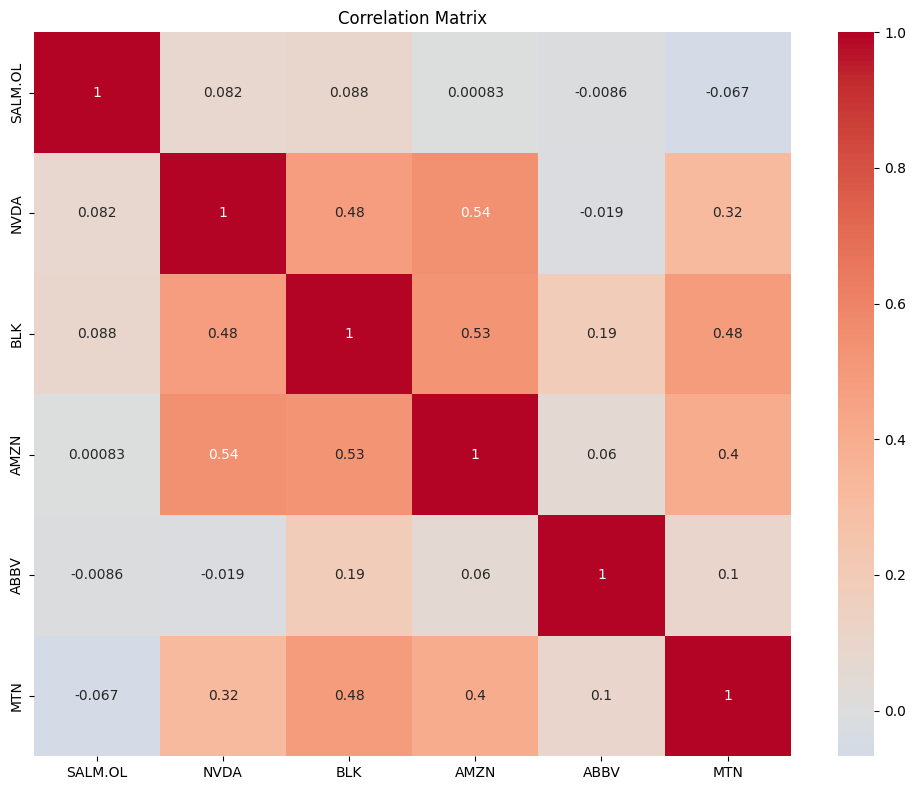

In [72]:
# Calculate log returns

returns = df.pct_change().dropna()

mean_returns = returns.mean()
cov_matrix = returns.cov()

# plot correlogram
plt.figure(figsize=(10, 8))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [73]:
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

def objective(weights):
    return portfolio_volatility(weights, cov_matrix)

In [74]:
# Define our constraints
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(tickers)))

In [75]:
# First guess portfolio, equal weights
initial_weights = np.array([1/len(tickers)] * len(tickers))

In [76]:
# Let's optimize!
result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Get optimal weights
optimal_weights = result.x

In [77]:
# Calculate portfolio metrics
port_vol = portfolio_volatility(optimal_weights, cov_matrix)
port_ret = np.sum(mean_returns * optimal_weights) * 252  # to annualize it

In [78]:
# Print out some results
print("\n=== Minimum Variance Portfolio ===")
print("\nOptimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

print(f"\nPortfolio Annual Volatility: {port_vol:.4%}")
print(f"Portfolio Expected Annual Return: {port_ret:.4%}")


=== Minimum Variance Portfolio ===

Optimal Weights:
SALM.OL: 0.1916
NVDA: 0.0000
BLK: 0.1108
AMZN: 0.0716
ABBV: 0.4588
MTN: 0.1672

Portfolio Annual Volatility: 15.9052%
Portfolio Expected Annual Return: 11.2146%


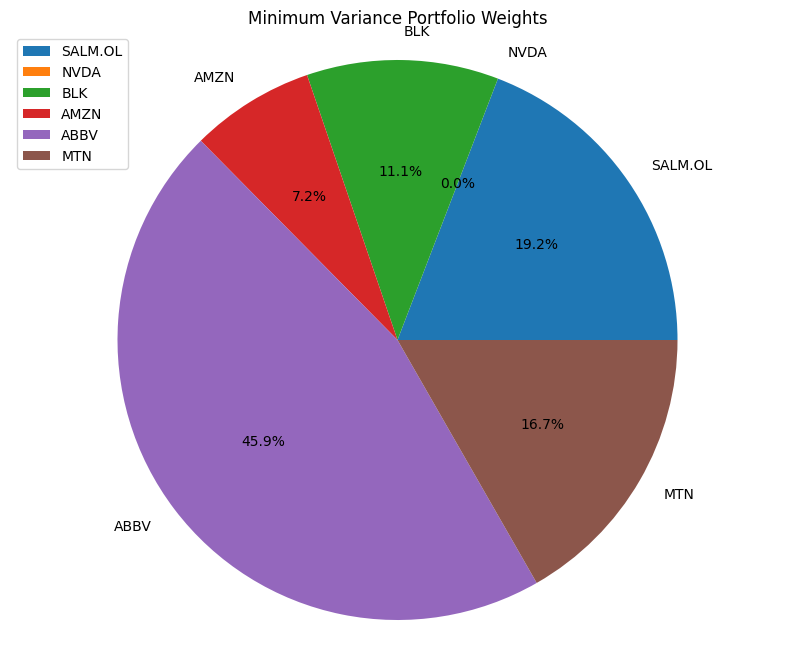

In [79]:
# Plot pie chart of weights
plt.figure(figsize=(10, 8))
plt.pie(optimal_weights, labels=tickers, autopct='%1.1f%%')
plt.title('Minimum Variance Portfolio Weights')
plt.axis('equal')
plt.legend()
plt.show()

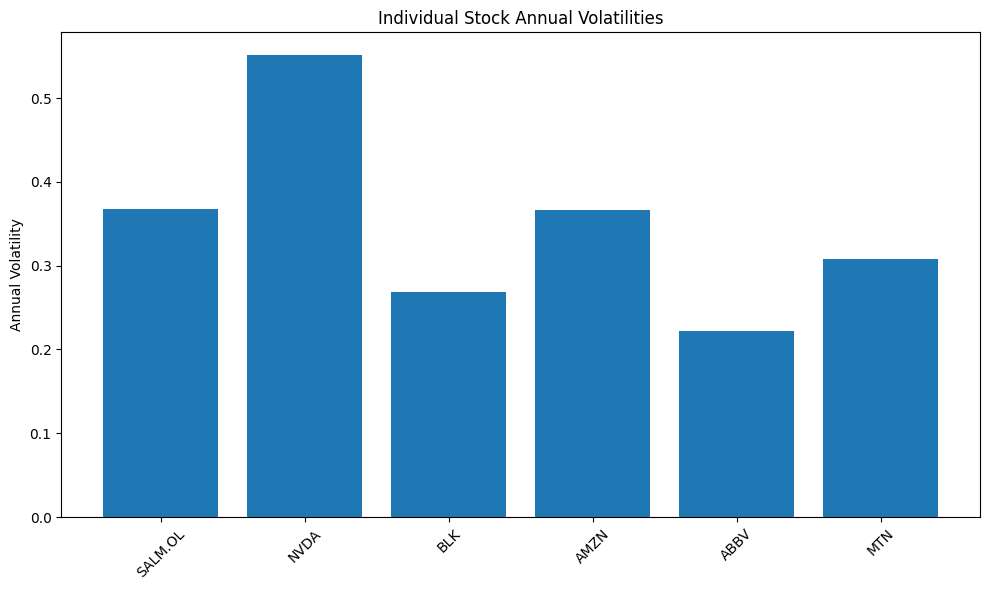

In [80]:
# Plot individual stock volatilities for comparison
individual_vols = np.sqrt(np.diag(cov_matrix)) * np.sqrt(252)
plt.figure(figsize=(10, 6))
plt.bar(tickers, individual_vols)
plt.title('Individual Stock Annual Volatilities')
plt.xticks(rotation=45)
plt.ylabel('Annual Volatility')
plt.tight_layout()
plt.show()

In [81]:
# Get minimum variance weights
def get_min_var_weights(returns_data):
    cov_matrix = returns_data.cov()

    def portfolio_volatility(weights):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(returns_data.columns)))
    initial_weights = np.array([1/len(returns_data.columns)] * len(returns_data.columns))

    result = minimize(portfolio_volatility, initial_weights, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    return result.x

In [82]:
# Calculate portfolio weights with rebalancing
def calculate_portfolio_value_with_rebalancing(returns, rebalance_func, rebalance_dates):
    portfolio_values = pd.Series(index=returns.index, data=np.nan)
    portfolio_values.iloc[0] = 1.0

    weights = rebalance_func(returns.iloc[:1])  # Initial weights

    for i in range(len(rebalance_dates)-1):
        start_date = rebalance_dates[i]
        end_date = rebalance_dates[i+1]

        # Get data for this period
        mask = (returns.index >= start_date) & (returns.index <= end_date)
        period_returns = returns[mask]

        # Calculate weights at the start of the period
        if i > 0:  # Don't recalculate for the first period
            hist_data = returns[returns.index <= start_date]
            weights = rebalance_func(hist_data)

        # Calculate period returns
        period_portfolio_returns = (period_returns * weights).sum(axis=1)

        # Calculate cumulative returns for this period
        cumulative_returns = (1 + period_portfolio_returns).cumprod()

        # Scale by previous portfolio value
        if i > 0:
            prev_value = portfolio_values[portfolio_values.index < start_date][-1]
            portfolio_values[mask] = prev_value * cumulative_returns
        else:
            portfolio_values[mask] = cumulative_returns

    return portfolio_values

In [83]:
# Define a rebalancer
def equal_weight_func(returns_data):
    return np.array([1/len(tickers)] * len(tickers))

In [84]:
# Calculate strategy returns
# 1. Equal weighted (no rebalancing)
equal_weights = equal_weight_func(returns)
equal_weighted_portfolio = (1 + (returns * equal_weights).sum(axis=1)).cumprod()

# 2. Minimum variance (no rebalancing)
min_var_weights = get_min_var_weights(returns)
min_var_portfolio = (1 + (returns * min_var_weights).sum(axis=1)).cumprod()

# Create monthly dates for rebalancing
monthly_dates = returns.index[returns.index.is_month_end]
if returns.index[-1] not in monthly_dates:
    monthly_dates = monthly_dates.append(pd.Index([returns.index[-1]]))

# 3. Minimum variance (monthly rebalancing)
min_var_rebal_portfolio = calculate_portfolio_value_with_rebalancing(
    returns, get_min_var_weights, monthly_dates)

# 4. Shannon's Demon (monthly rebalancing)
shannon_portfolio = calculate_portfolio_value_with_rebalancing(
    returns, equal_weight_func, monthly_dates)

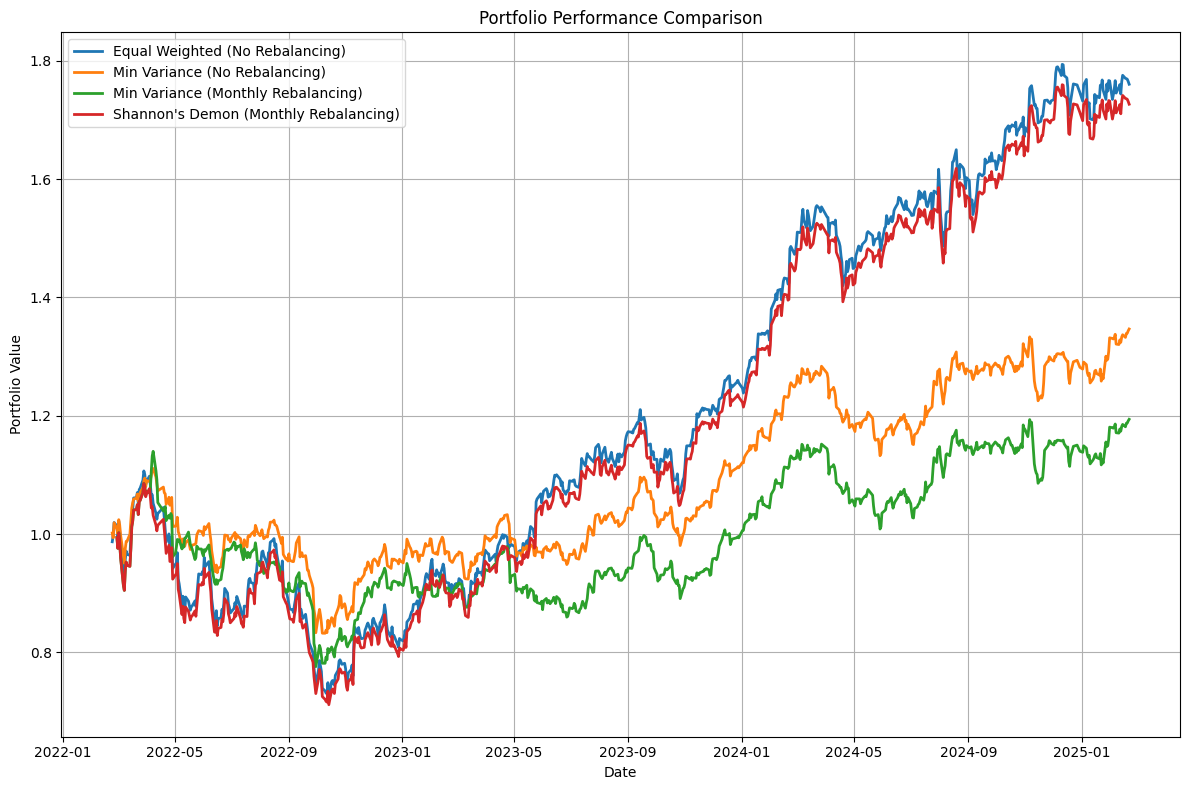

In [85]:
# Plot results
plt.figure(figsize=(12, 8))
plt.plot(equal_weighted_portfolio, label='Equal Weighted (No Rebalancing)', linewidth=2)
plt.plot(min_var_portfolio, label='Min Variance (No Rebalancing)', linewidth=2)
plt.plot(min_var_rebal_portfolio, label='Min Variance (Monthly Rebalancing)', linewidth=2)
plt.plot(shannon_portfolio, label="Shannon's Demon (Monthly Rebalancing)", linewidth=2)
plt.title('Portfolio Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Portfolio Performance Analysis

The graphs reveal several interesting patterns across different portfolio strategies:

### Performance Comparison
- Equal Weighted (No Rebalancing) and Shannon's Demon show the strongest performance, reaching ~1.8x initial value by 2025
- Both strategies track very closely, suggesting monthly rebalancing to equal weights captures similar benefits
- Minimum Variance strategies (both with and without rebalancing) significantly underperform, reaching only ~1.2-1.3x initial value
- All strategies experienced a significant drawdown in late 2022, bottoming around 0.7-0.8x initial value

In [86]:
# Calculate performance metrics
strategies = {
    'Equal Weighted (No Rebalancing)': equal_weighted_portfolio,
    'Min Variance (No Rebalancing)': min_var_portfolio,
    'Min Variance (Monthly Rebalancing)': min_var_rebal_portfolio,
    "Shannon's Demon (Monthly Rebalancing)": shannon_portfolio
}

print("\n=== Performance Metrics ===")
for name, strategy in strategies.items():
    returns_series = strategy.pct_change().dropna()
    annual_return = (strategy[-1] / strategy[0]) ** (252/len(strategy)) - 1
    annual_vol = returns_series.std() * np.sqrt(252)
    sharpe = annual_return / annual_vol  # Assuming risk-free rate = 0 for simplicity
    max_drawdown = (strategy / strategy.cummax() - 1).min()

    print(f"\n{name}:")
    print(f"Annual Return: {annual_return:.2%}")
    print(f"Annual Volatility: {annual_vol:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")

# Calculate volatility harvesting effect
def calculate_volatility_harvesting(returns, weights):
    arithmetic_mean = np.sum(returns.mean() * weights) * 252
    geometric_mean = (1 + (returns * weights).sum(axis=1)).prod() ** (252/len(returns)) - 1
    return geometric_mean - arithmetic_mean

print("\n=== Volatility Harvesting Effect ===")
print(f"Shannon's Demon: {calculate_volatility_harvesting(returns, equal_weights):.2%}")
print(f"Min Variance: {calculate_volatility_harvesting(returns, min_var_weights):.2%}")


=== Performance Metrics ===

Equal Weighted (No Rebalancing):
Annual Return: 21.34%
Annual Volatility: 21.15%
Sharpe Ratio: 1.01
Maximum Drawdown: -34.45%

Min Variance (No Rebalancing):
Annual Return: 10.39%
Annual Volatility: 15.92%
Sharpe Ratio: 0.65
Maximum Drawdown: -25.09%

Min Variance (Monthly Rebalancing):
Annual Return: 6.10%
Annual Volatility: 17.47%
Sharpe Ratio: 0.35
Maximum Drawdown: -31.93%

Shannon's Demon (Monthly Rebalancing):
Annual Return: 20.03%
Annual Volatility: 21.10%
Sharpe Ratio: 0.95
Maximum Drawdown: -34.45%

=== Volatility Harvesting Effect ===
Shannon's Demon: -0.33%
Min Variance: -0.76%


After researching the literature, there are a few alternative methods we could try to use to generate outperformance. Sharpe ratio lends itself quite nicely as a general performance measure. To boost SR, you can either increase your Information Coefficient, or you can increase the number of trades you make. Simply put: either to be more correct in the trades you do make (thereby increasing your hit-rate), and/or to make more trades. 

Let's explore
- Risk Parity (Equal Risk Contribution)
- Black-Litternam Model
- Hierarchical Risk Parity (Lopez de Prado)
- Robust Mean-Variance Optimization
- Maximum Diversification Portfolio


## Risk Parity (Equal Risk Contribution)

In [87]:
def risk_parity_weights(returns):
    def risk_budget_objective(weights, args):
        cov = args[0]
        risk_target = args[1]
        portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        risk_contrib = weights * (np.dot(cov, weights)) / portfolio_vol
        return np.sum((risk_contrib - risk_target)**2)

    cov = returns.cov()
    n = len(returns.columns)
    risk_target = 1/n

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(n))

    result = minimize(risk_budget_objective, [1/n]*n, args=[cov, risk_target],
                     method='SLSQP', constraints=constraints, bounds=bounds)
    return result.x

## Black-Litterman Model

In [88]:
def black_litterman_weights(returns, market_caps, views=None, confidences=None):
    # Prior returns based on CAPM
    market_weights = market_caps / market_caps.sum()
    prior_returns = returns.mean() * 252

    # Risk aversion parameter
    risk_aversion = 2.5

    # Calculate posterior returns
    cov = returns.cov() * 252
    tau = 0.05  # Uncertainty in prior

    if views is None:
        posterior_returns = prior_returns
    else:
        # Implement views adjustment
        pass

    # Optimize using posterior returns
    def objective(weights):
        portfolio_return = np.sum(weights * posterior_returns)
        portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        return -portfolio_return + risk_aversion * portfolio_vol

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(returns.columns)))

    result = minimize(objective, market_weights, method='SLSQP',
                     constraints=constraints, bounds=bounds)
    return result.x

## Hierarchical Risk Parity (Lopez de Prado)

In [89]:
def hierarchical_risk_parity(returns):
    # Calculate correlation matrix
    corr = returns.corr()

    # Convert correlation matrix to distance matrix
    dist = np.sqrt(0.5 * (1 - corr))

    # Convert to condensed distance matrix
    condensed_dist = []
    n = len(dist)
    for i in range(n):
        for j in range(i+1, n):
            condensed_dist.append(dist.iloc[i,j])
    condensed_dist = np.array(condensed_dist)

    # Ensure no NaN values
    if np.any(np.isnan(condensed_dist)):
        condensed_dist = np.nan_to_num(condensed_dist, nan=0.0)

    # Hierarchical clustering
    link = sch.linkage(condensed_dist, 'single')

    # Get quasi-diagonal matrix
    sorted_idx = sch.leaves_list(link)

    # Calculate inverse variance weights
    var = returns.var()
    inv_var = 1/var
    weights = inv_var/inv_var.sum()

    # Recursive bisection
    def cluster_var(cov, items):
        return np.sqrt(np.sum(np.outer(cov[items], cov[items])))

    def recursive_bisection(cov, items):
        if len(items) == 1:
            return

        mid = len(items)//2
        recursive_bisection(cov, items[:mid])
        recursive_bisection(cov, items[mid:])

        left_cluster = items[:mid]
        right_cluster = items[mid:]

        left_var = cluster_var(cov, left_cluster)
        right_var = cluster_var(cov, right_cluster)

        alpha = 1 - left_var/(left_var + right_var)

        weights[left_cluster] *= alpha
        weights[right_cluster] *= (1-alpha)

    # Apply recursive bisection
    recursive_bisection(returns.std(), sorted_idx)

    return weights.values

## Robust Mean-Variance Optimization

In [90]:
def robust_optimization(returns, uncertainty=0.1):
    mean_returns = returns.mean() * 252
    cov = returns.cov() * 252

    # Add uncertainty to estimates
    robust_means = mean_returns - uncertainty * np.sqrt(np.diag(cov))
    robust_cov = cov * (1 + uncertainty)

    def objective(weights):
        portfolio_return = np.sum(weights * robust_means)
        portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(robust_cov, weights)))
        return -portfolio_return/portfolio_vol  # Maximize Sharpe

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(returns.columns)))

    result = minimize(objective, [1/len(returns.columns)]*len(returns.columns),
                     method='SLSQP', constraints=constraints, bounds=bounds)
    return result.x

## Maximum Diversification Portfolio

In [91]:
def maximum_diversification(returns):
    cov = returns.cov()
    vols = np.sqrt(np.diag(cov))

    def neg_diversification_ratio(weights):
        portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        weighted_vols = np.sum(weights * vols)
        return -weighted_vols/portfolio_vol

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(returns.columns)))

    result = minimize(neg_diversification_ratio, [1/len(returns.columns)]*len(returns.columns),
                     method='SLSQP', constraints=constraints, bounds=bounds)
    return result.x

## Comparison

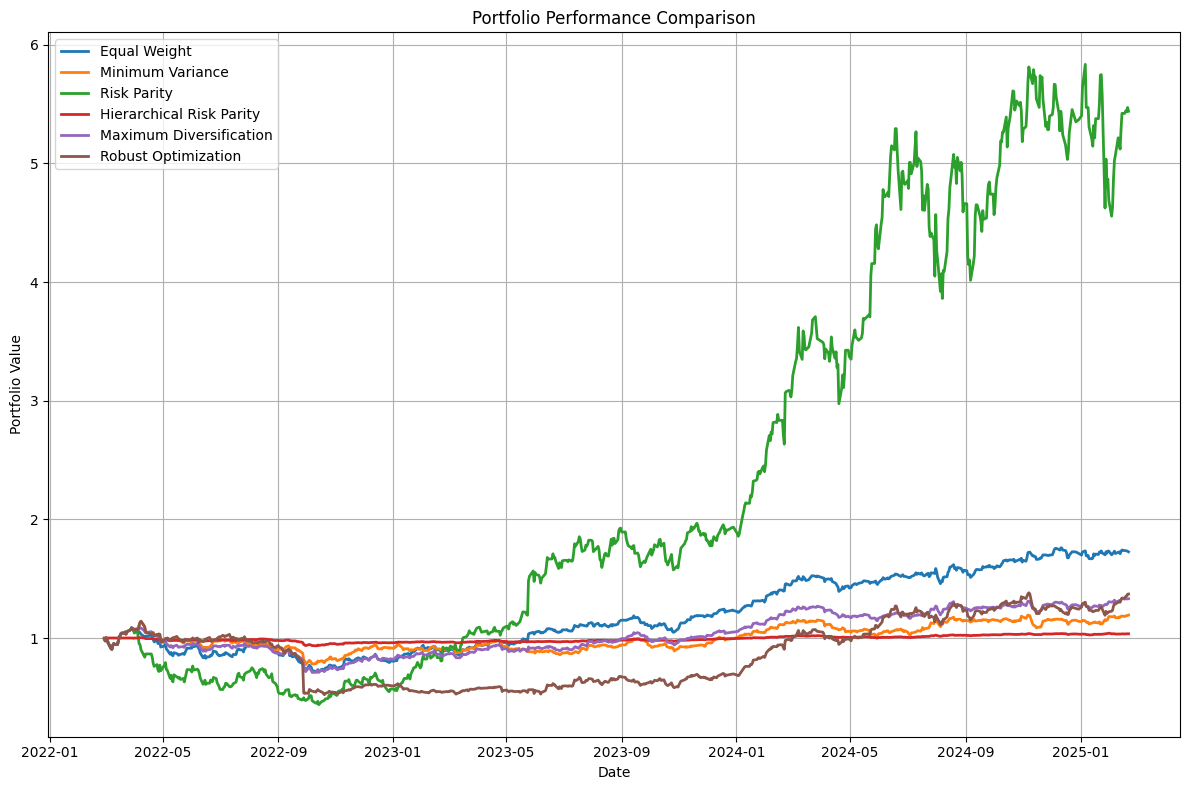


Performance Metrics:
                          Annual Return  Volatility  Sharpe  Max Drawdown
Equal Weight                     0.2003      0.2110  0.9490       -0.3445
Minimum Variance                 0.0610      0.1747  0.3494       -0.3193
Risk Parity                      0.7613      0.5393  1.4116       -0.5965
Hierarchical Risk Parity         0.0117      0.0288  0.4074       -0.0684
Maximum Diversification          0.1003      0.1738  0.5771       -0.3470
Robust Optimization              0.1112      0.3138  0.3543       -0.5423


In [92]:
# Create dictionary of strategies
strategies = {
    'Equal Weight': equal_weight_func,
    'Minimum Variance': get_min_var_weights,
    'Risk Parity': risk_parity_weights,
    'Hierarchical Risk Parity': hierarchical_risk_parity,
    'Maximum Diversification': maximum_diversification,
    'Robust Optimization': lambda x: robust_optimization(x, uncertainty=0.1)
}

# Compare all strategies
results = {}
for name, strategy in strategies.items():
    try:
        portfolio_values = calculate_portfolio_value_with_rebalancing(
            returns, strategy, monthly_dates)
        results[name] = portfolio_values
    except Exception as e:
        print(f"Error in strategy {name}: {str(e)}")
        continue

# Calculate metrics for all strategies
metrics = pd.DataFrame(columns=['Annual Return', 'Volatility', 'Sharpe', 'Max Drawdown'])
for name, values in results.items():
    returns_series = values.pct_change().dropna()
    annual_return = (values[-1]/values[0])**(252/len(values)) - 1
    vol = returns_series.std() * np.sqrt(252)
    sharpe = annual_return/vol
    max_dd = (values/values.cummax() - 1).min()

    metrics.loc[name] = [annual_return, vol, sharpe, max_dd]

# Plot results
plt.figure(figsize=(12, 8))
for name, values in results.items():
    plt.plot(values, label=name, linewidth=2)
plt.title('Portfolio Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display metrics
print("\nPerformance Metrics:")
print(metrics.round(4))

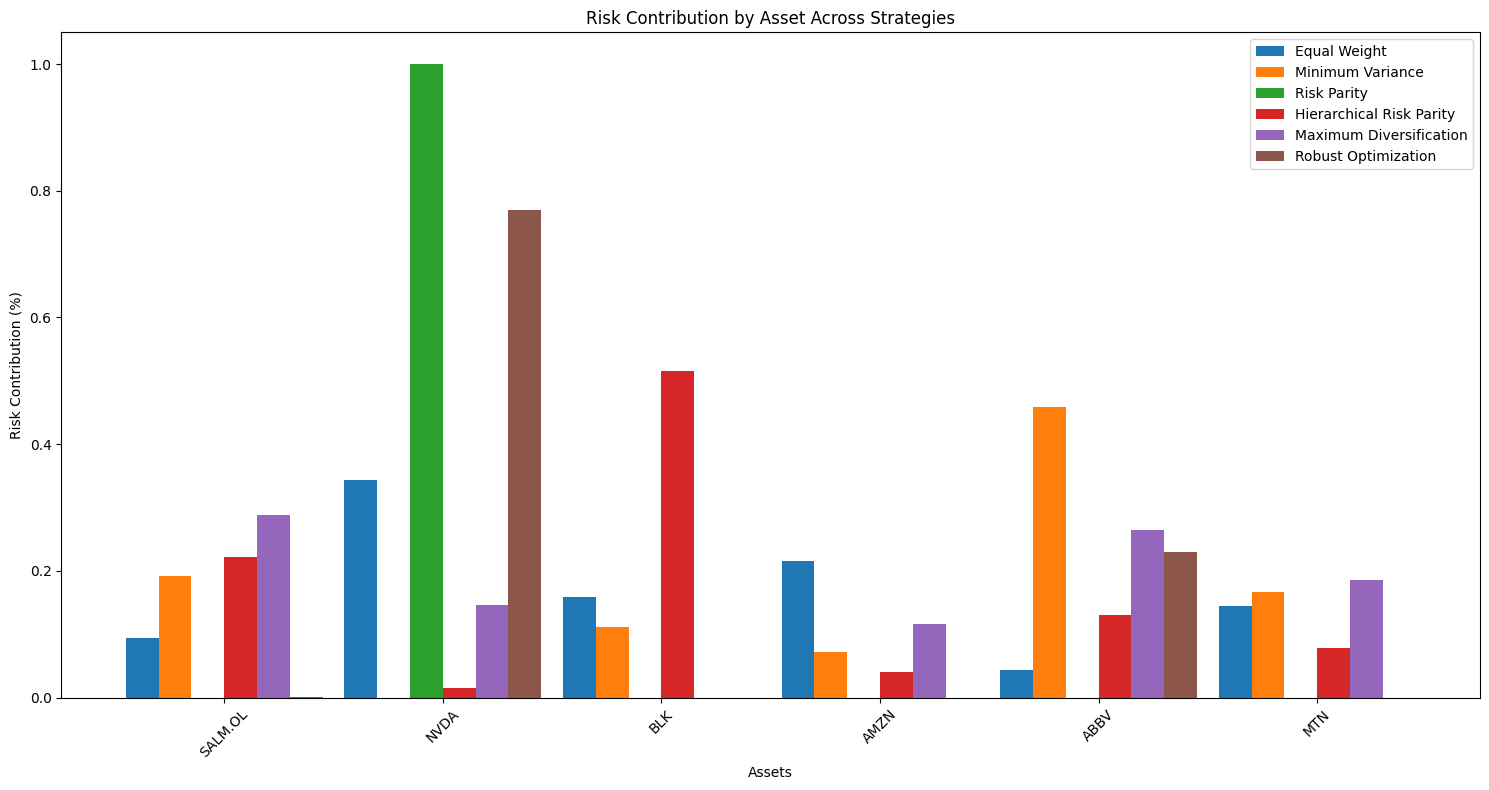


Risk Contributions by Strategy:
         Equal Weight  Minimum Variance  Risk Parity  \
SALM.OL         0.095             0.192          0.0   
NVDA            0.343             0.000          1.0   
BLK             0.158             0.111          0.0   
AMZN            0.216             0.072          0.0   
ABBV            0.043             0.459         -0.0   
MTN             0.145             0.167          0.0   

         Hierarchical Risk Parity  Maximum Diversification  \
SALM.OL                     0.222                    0.289   
NVDA                        0.016                    0.145   
BLK                         0.515                    0.000   
AMZN                        0.040                    0.116   
ABBV                        0.130                    0.265   
MTN                         0.078                    0.185   

         Robust Optimization  
SALM.OL                0.001  
NVDA                   0.770  
BLK                    0.000  
AMZN           

In [94]:
def analyze_risk_contributions(weights, returns):
    cov = returns.cov()
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    marginal_contrib = np.dot(cov, weights)
    risk_contrib = weights * marginal_contrib / port_vol
    
    # Percentage contribution to risk
    risk_contrib_pct = risk_contrib / risk_contrib.sum()
    
    return pd.Series(risk_contrib_pct, index=returns.columns)

# Calculate risk contributions for all strategies
risk_contributions = {}
for name, strategy in strategies.items():
    try:
        weights = strategy(returns)
        risk_contributions[name] = analyze_risk_contributions(weights, returns)
    except Exception as e:
        print(f"Could not calculate risk contributions for {name}: {str(e)}")

# Convert to DataFrame
risk_contributions_df = pd.DataFrame(risk_contributions)

# Plot with different colors for each strategy
plt.figure(figsize=(15, 8))
bar_width = 0.15
positions = np.arange(len(returns.columns))

for idx, (strategy_name, contributions) in enumerate(risk_contributions_df.items()):
    plt.bar(positions + idx * bar_width, 
            contributions, 
            bar_width, 
            label=strategy_name)

plt.title('Risk Contribution by Asset Across Strategies')
plt.xlabel('Assets')
plt.ylabel('Risk Contribution (%)')
plt.xticks(positions + bar_width * (len(risk_contributions_df.columns) - 1) / 2, 
           returns.columns, 
           rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Print numerical values
print("\nRisk Contributions by Strategy:")
print(risk_contributions_df.round(3))

### Risk Contribution Analysis
- Risk Parity shows extremely concentrated risk in NVDA (~100% contribution)
- Minimum Variance concentrates risk in ABBV (~45%) with moderate allocations to other stocks
- Equal Weight shows more balanced risk contributions across assets, though still with notable NVDA exposure (~35%)

### Key Insights
1. Interestingly, rebalancing does not appear beneficial (though the literature purports otherwise), as both rebalancing strategies outperform their static counterparts. I suspect rebalancing appears to have had very little effect in boosting Sharpe here, because of the inclusion of NVDA, which has had a stellar year.
2. Simple equal weighting performs surprisingly well, suggesting complex optimization may not add value in this case
3. The high concentration in NVDA under Risk Parity likely explains its strong performance given NVDA's exceptional returns
4. Minimum Variance strategies achieved their goal of lower volatility but at the cost of significant underperformance

The results suggest that for this particular set of assets and time period, simpler strategies focusing on diversification through equal weighting outperformed more sophisticated variance optimization approaches, which is quite interesting.